In [4]:
import sys, os

# Projektroot = eine Ebene über notebooks/
project_root = os.path.abspath("..")
print("Project root:", project_root)

if project_root not in sys.path:
    sys.path.append(project_root)

print("sys.path enthält project_root:", project_root in sys.path)


Project root: /Users/andregrau/Desktop/Thesis/Tool/Python_Tool/simLIS
sys.path enthält project_root: True


In [5]:
from model.sim_model import load_scenario, simulate_load_profile

scenario_name = "office"            # gewünschtes Scenario eingeben
scenario_path = f"../scenarios/{scenario_name}.yaml"

scenario = load_scenario(scenario_path)
timestamps, load_kw, sessions = simulate_load_profile(scenario)

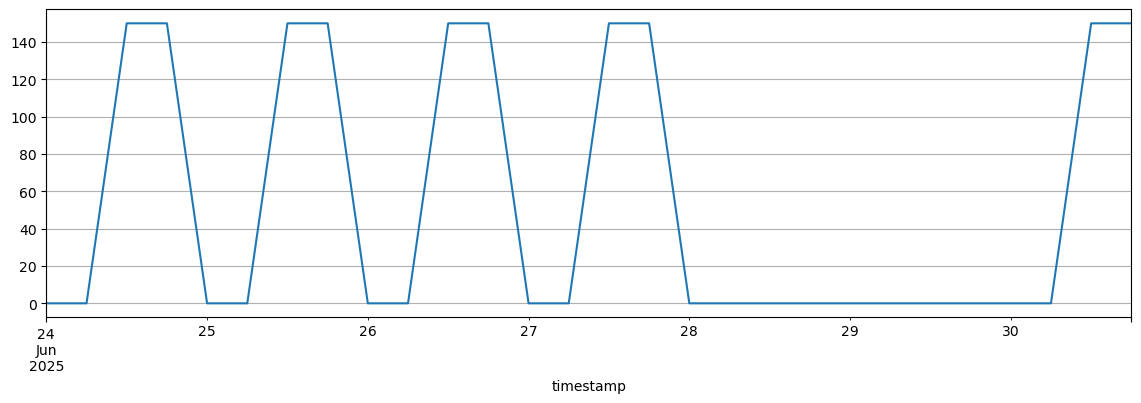

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"timestamp": timestamps, "load_kw": load_kw})
df = df.set_index("timestamp")

df["load_kw"].plot(figsize=(14,4))
plt.grid(True)
plt.show()


In [7]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from model.sim_model import load_scenario, simulate_load_profile
from model.sim_extended import extend_profile


In [8]:
scenario_name = "office"            # hier gewünschtes Szenario eingeben
scenario_path = f"../scenarios/{scenario_name}.yaml"

print("Verwendetes Szenario:", scenario_path)           # Kontrolle, welches Szenario untersucht wird

scenario = load_scenario(scenario_path)

timestamps_base, load_kw_base, sessions = simulate_load_profile(scenario)           # lädt die Basissimulation

timestamps_base[0], timestamps_base[-1]                 # Kontrolle, ab und bis wann die Basissimulation läuft
print(f"Erster Timestamp: {timestamps_base[0]}")
print(f"Letzter Timestamp: {timestamps_base[-1]}")

Verwendetes Szenario: ../scenarios/office.yaml
Erster Timestamp: 2025-06-24 00:00:00
Letzter Timestamp: 2025-06-30 18:00:00


In [9]:
base_days = scenario["sim_horizon_days"]            

# Zielhorizont: entweder aus YAML (result_horizon_days) oder = base_days
target_days = scenario.get("result_horizon_days", base_days)

print(f"Basis-Simulationshorizont: {base_days} Tage")           # Kontrolle, wie lange die Basissimulation ist
print(f"Zielhorizont (Ausgabe): {target_days} Tage")            # Kontrolle, wie lange der Simulationshorizont ist

if target_days > base_days:
    timestamps, load_kw = extend_profile(
        timestamps_base,
        load_kw_base,
        target_days=target_days,
    )
else:
    timestamps, load_kw = timestamps_base, load_kw_base   

Basis-Simulationshorizont: 7 Tage
Zielhorizont (Ausgabe): 28 Tage


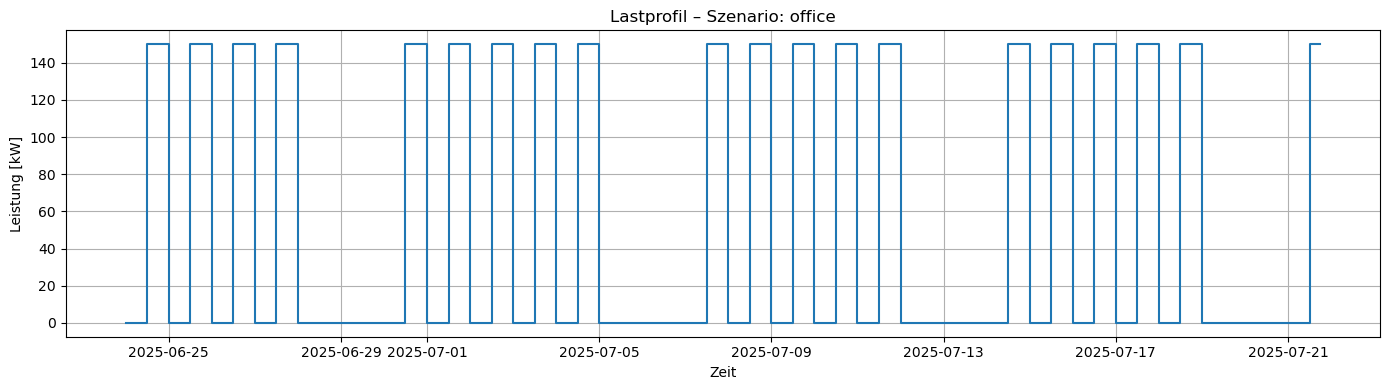

In [10]:
plt.figure(figsize=(14, 4))
plt.step(timestamps, load_kw, where="post")
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(f"Lastprofil – Szenario: {scenario.get('name', scenario_name)}")
plt.grid(True)
plt.tight_layout()
plt.show()
